In [2]:
import grass.script as gs
import pandas as pd
import os

# -------------------------
# PARAMETERS & CLASS SETUP
# -------------------------

# Updated resolution (30m instead of 300m)
PIXEL_AREA_KM2 = 0.0009  # 30m x 30m = 900 m² = 0.0009 km²

# Class labels and color mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Specific periods requested
periods = [("1990", "2000"), ("2000", "2010"), ("2010", "2020")]

# Unique prefix for outputs
unique_prefix = "tevere_30m_transition"

# Create output directory
os.makedirs("transition_outputs_30m", exist_ok=True)

# -------------------------
# TRANSITION MATRIX FUNCTION (Updated for 30m resolution)
# -------------------------

def compute_transition_matrix(year_start, year_end):
    raster1 = f"tevere_lc_{year_start}"
    raster2 = f"tevere_lc_{year_end}"
    transition_map = f"{unique_prefix}_{year_start}_{year_end}"

    print(f"\nProcessing 30m transition: {year_start} → {year_end}")

    # Set computational region with 30m resolution
    gs.run_command("g.region", raster=raster1, res=30)

    # Create transition map (from*1000 + to)
    gs.mapcalc(f"{transition_map} = {raster1} * 1000 + {raster2}", overwrite=True)

    # Get transition statistics with adjusted area calculation
    stats = gs.read_command("r.stats", flags="cn", input=transition_map, sep=":")
    if not stats.strip():
        print(f"No transitions found between {raster1} and {raster2}")
        return None

    data = []
    for line in stats.strip().splitlines():
        code, count = line.split(":")
        from_class = int(code) // 1000
        to_class = int(code) % 1000

        if from_class in class_labels and to_class in class_labels:
            data.append({
                "From": from_class,
                "To": to_class,
                "Count": int(count),
                "Area_km2": int(count) * PIXEL_AREA_KM2,  # Using 30m resolution area
                "Resolution": "30m",
                "Period": f"{year_start}-{year_end}"
            })

    # Save to CSV
    df = pd.DataFrame(data)
    output_file = f"transition_outputs_30m/{unique_prefix}_matrix_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False)
    print(f"✔ Saved 30m CSV: {output_file}")
    return df

# -------------------------
# IMPROVED TRANSITION MAP VISUALIZATION (30m optimized)
# -------------------------

def generate_transition_map(year_start, year_end):
    r1 = f"tevere_lc_{year_start}"
    r2 = f"tevere_lc_{year_end}"
    map_name = f"{unique_prefix}_visual_{year_start}_{year_end}"

    print(f"\nGenerating 30m transition map: {map_name}")
    
    # Set region with explicit 30m resolution
    gs.run_command("g.region", raster=r1, res=30)
    gs.mapcalc(f"{map_name} = {r1} * 1000 + {r2}", overwrite=True)

    # Create enhanced color table for 30m details
    color_rules = []
    for from_class in class_labels:
        for to_class in class_labels:
            code = from_class * 1000 + to_class
            color = blend_colors_30m(from_class, to_class)
            color_rules.append(f"{code} {color}")
    
    # Apply color rules
    gs.write_command("r.colors", map=map_name, rules="-", stdin="\n".join(color_rules))
    
    # Export high-quality GeoTIFF optimized for 30m data
    output_tif = f"transition_outputs_30m/{map_name}.tif"
    gs.run_command("r.out.gdal", input=map_name, output=output_tif, 
                  format="GTiff", createopt="COMPRESS=LZW,TILED=YES", overwrite=True)
    
    print(f"✔ Saved 30m transition map: {output_tif}")
    return map_name

def blend_colors_30m(from_class, to_class):
    """Enhanced color blending for 30m resolution data"""
    # Updated color definitions for better 30m visualization
    class_colors = {
        'Shrubland': '160 82 45',
        'Grassland': '50 205 50',  # Brighter for 30m
        'Cropland': '255 215 0',
        'Built-up': '139 69 19',
        'Water': '30 144 255',
        'Forest': '0 128 0',       # Darker green
        'Wetland': '65 105 225',
        'Bareland': '210 180 140',
        'Permanent ice and Snow': '220 230 240',  # Lighter
        'Lichens and mosses': '169 209 169',
        'No data': '255 255 255'
    }
    
    r1, g1, b1 = map(int, class_colors[class_labels[from_class]].split())
    r2, g2, b2 = map(int, class_colors[class_labels[to_class]].split())
    
    # Enhanced blending for 30m clarity
    return f"{(r1*3 + r2*7)//10} {(g1*3 + g2*7)//10} {(b1*3 + b2*7)//10}"  # 30/70 blend

# -------------------------
# PROCESS ALL PERIODS (30m version)
# -------------------------

# Process all transition periods with 30m resolution
all_dfs = []
for y1, y2 in periods:
    # Compute transition matrix with 30m calculations
    df = compute_transition_matrix(y1, y2)
    if df is not None:
        all_dfs.append(df)
    
    # Generate visual map with special handling for 2000-2010
    if y1 == "2000" and y2 == "2010":
        print("\nCreating enhanced 30m visualization for 2000-2010 period")
        generate_transition_map(y1, y2)
    else:
        generate_transition_map(y1, y2)

# Combine all matrices with resolution noted
if all_dfs:
    combined_df = pd.concat(all_dfs)
    combined_file = f"transition_outputs_30m/{unique_prefix}_matrix_ALL.csv"
    combined_df.to_csv(combined_file, index=False)
    print(f"\n✔ Combined 30m matrix saved: {combined_file}")

print("\n30m resolution processing complete! All outputs saved in 'transition_outputs_30m' directory")




Processing 30m transition: 1990 → 2000


✔ Saved 30m CSV: transition_outputs_30m/tevere_30m_transition_matrix_1990_2000.csv

Generating 30m transition map: tevere_30m_transition_visual_1990_2000


Color table for raster map <tevere_30m_transition_visual_1990_2000> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_30m/tevere_30m_transition_visual_1990_2000.tif>
created.


✔ Saved 30m transition map: transition_outputs_30m/tevere_30m_transition_visual_1990_2000.tif

Processing 30m transition: 2000 → 2010


✔ Saved 30m CSV: transition_outputs_30m/tevere_30m_transition_matrix_2000_2010.csv

Creating enhanced 30m visualization for 2000-2010 period

Generating 30m transition map: tevere_30m_transition_visual_2000_2010


Color table for raster map <tevere_30m_transition_visual_2000_2010> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
<transition_outputs_30m/tevere_30m_transition_visual_2000_2010.tif>
created.


✔ Saved 30m transition map: transition_outputs_30m/tevere_30m_transition_visual_2000_2010.tif

Processing 30m transition: 2010 → 2020


✔ Saved 30m CSV: transition_outputs_30m/tevere_30m_transition_matrix_2010_2020.csv

Generating 30m transition map: tevere_30m_transition_visual_2010_2020


Color table for raster map <tevere_30m_transition_visual_2010_2020> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...



✔ Saved 30m transition map: transition_outputs_30m/tevere_30m_transition_visual_2010_2020.tif

✔ Combined 30m matrix saved: transition_outputs_30m/tevere_30m_transition_matrix_ALL.csv

30m resolution processing complete! All outputs saved in 'transition_outputs_30m' directory


r.out.gdal complete. File
<transition_outputs_30m/tevere_30m_transition_visual_2010_2020.tif>
created.


Displaying Transition Matrices...


/var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/ipykernel_11394/3238732998.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


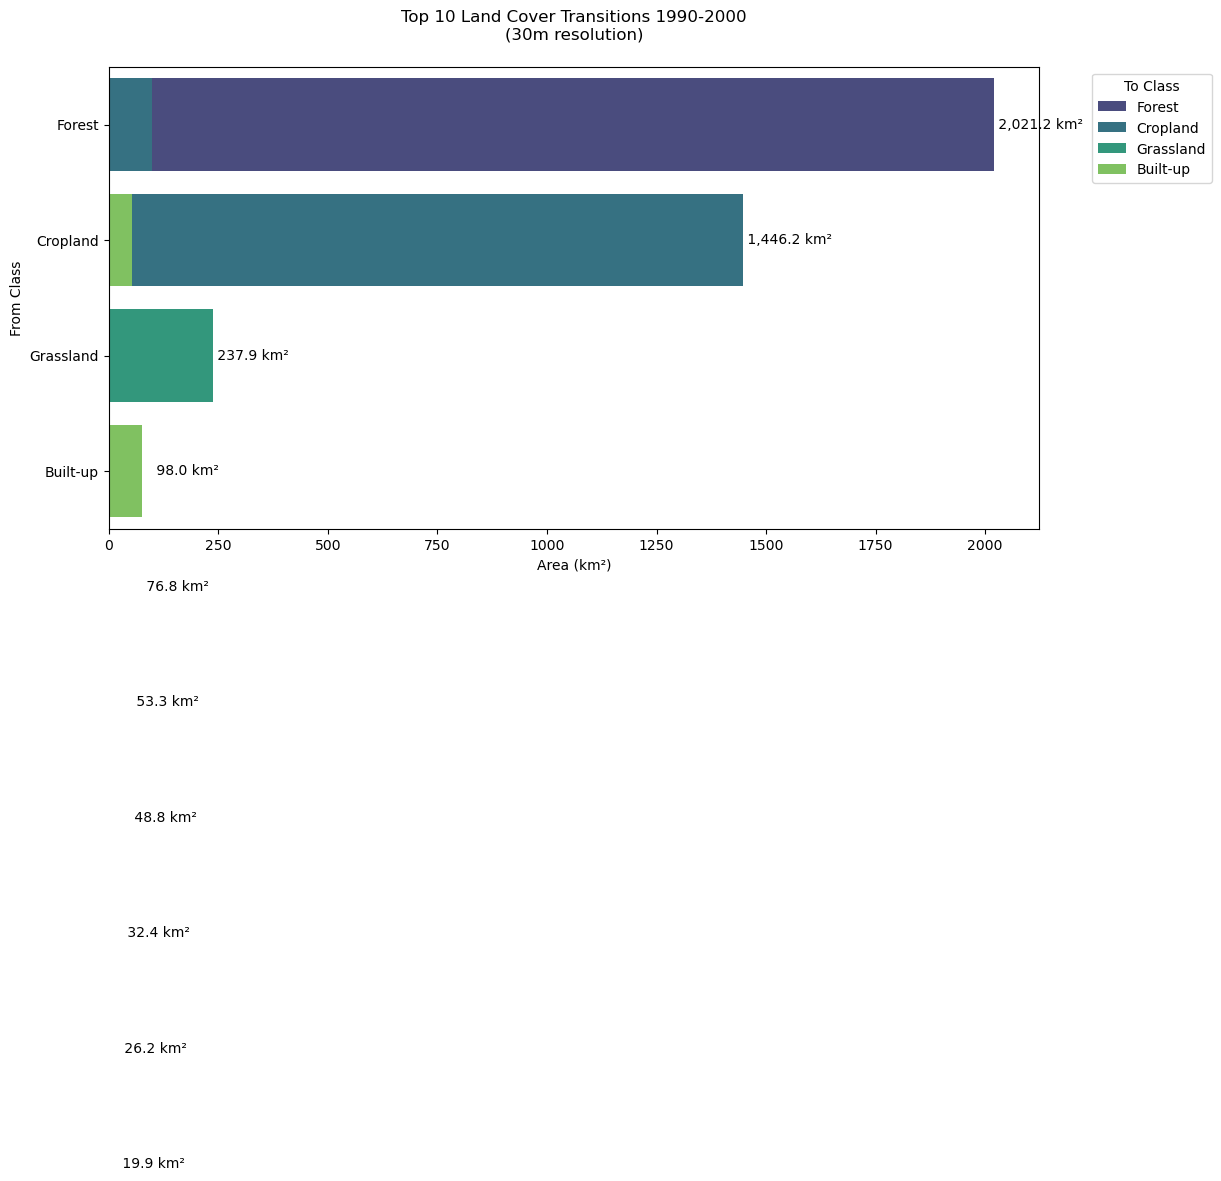

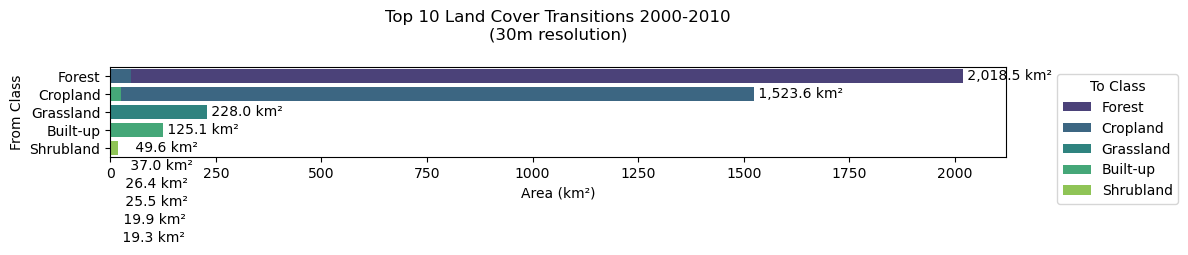

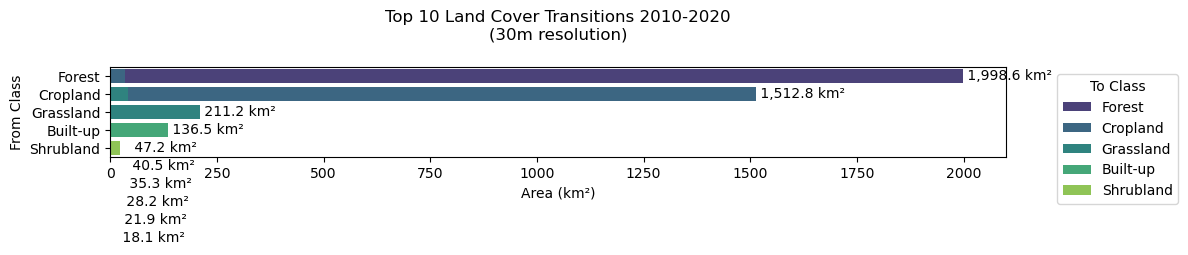

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Set display options for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Directory containing your outputs
output_dir = "transition_outputs_30m"

# -------------------------
# LOAD AND DISPLAY TRANSITION MATRICES
# -------------------------

def load_and_display_transitions():
    # Load all individual period CSVs
    periods = [
        ("1990", "2000", f"{output_dir}/tevere_30m_transition_matrix_1990_2000.csv"),
        ("2000", "2010", f"{output_dir}/tevere_30m_transition_matrix_2000_2010.csv"), 
        ("2010", "2020", f"{output_dir}/tevere_30m_transition_matrix_2010_2020.csv")
    ]
    
    # Load combined matrix
    combined_df = pd.read_csv(f"{output_dir}/tevere_30m_transition_matrix_ALL.csv")
    
    # Class names for display
    class_names = {
        5: 'Shrubland',
        7: 'Grassland',
        8: 'Cropland',
        9: 'Wetland',
        11: 'Lichens',
        12: 'Bareland',
        13: 'Built-up',
        15: 'Water',
        16: 'Ice/Snow',
        20: 'Forest',
        255: 'No data'
    }
    
    # Create styled DataFrames for each period
    for start, end, path in periods:
        try:
            df = pd.read_csv(path)
            if not df.empty:
                # Apply class names
                df['From'] = df['From'].map(class_names)
                df['To'] = df['To'].map(class_names)
                
                # Calculate percentages
                total_area = df['Area_km2'].sum()
                df['% of Total'] = (df['Area_km2'] / total_area * 100).round(2)
                
                # Sort by area
                df = df.sort_values('Area_km2', ascending=False)
                
                # Create styled DataFrame
                styled_df = df.style\
                    .background_gradient(subset=['Area_km2'], cmap='YlOrBr')\
                    .format({'Area_km2': '{:,.2f} km²', '% of Total': '{:.1f}%'})\
                    .set_caption(f'<h2>Land Cover Transition {start}-{end} (30m resolution)</h2>')\
                    .set_properties(**{
                        'text-align': 'center',
                        'border': '1px solid black'
                    })
                
                # Display in notebook
                display(styled_df)
                
                # Plot top transitions
                plot_top_transitions(df, start, end)
                
        except FileNotFoundError:
            print(f"File not found: {path}")
    
    # Display combined matrix
    if not combined_df.empty:
        combined_df['From'] = combined_df['From'].map(class_names)
        combined_df['To'] = combined_df['To'].map(class_names)
        
        styled_combined = combined_df.style\
            .background_gradient(subset=['Area_km2'], cmap='YlOrBr')\
            .format({'Area_km2': '{:,.2f} km²'})\
            .set_caption('<h2>All Transitions Combined (30m resolution)</h2>')\
            .set_properties(**{
                'text-align': 'center',
                'border': '1px solid black'
            })
        
        display(styled_combined)

# -------------------------
# VISUALIZE TOP TRANSITIONS
# -------------------------

def plot_top_transitions(df, start, end):
    # Get top 10 transitions
    top10 = df.nlargest(10, 'Area_km2')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar plot with transition labels
    sns.barplot(
        x='Area_km2', 
        y='From',
        hue='To',
        data=top10,
        palette='viridis',
        dodge=False
    )
    
    # Customize plot
    plt.title(f'Top 10 Land Cover Transitions {start}-{end}\n(30m resolution)', pad=20)
    plt.xlabel('Area (km²)')
    plt.ylabel('From Class')
    plt.legend(title='To Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for i, value in enumerate(top10['Area_km2']):
        plt.text(value, i, f' {value:,.1f} km²', va='center')
    
    plt.tight_layout()
    plt.show()

# -------------------------
# RUN THE DISPLAY
# -------------------------

# Display all transition matrices
print("Displaying Transition Matrices...")
load_and_display_transitions()

# Add some CSS styling for Jupyter
display(HTML("""
<style>
    .dataframe th {
        background-color: #4CAF50 !important;
        color: white !important;
        text-align: center !important;
    }
    .dataframe td {
        text-align: center !important;
    }
    h2 {
        color: #2e86c1;
    }
</style>
"""))



In [18]:
import grass.script as gs

def check_class_definitions():
    """Verify that CLASS_LABELS and COLOR_MAP match the actual raster classes"""
    # Get all unique values in the raster
    stats = gs.read_command("r.stats", flags="n", input=raster_map).strip().split()
    unique_values = set(int(val) for val in stats if val)
    
    print("=== Class Definition Verification ===")
    print(f"Found {len(unique_values)} unique values in raster '{raster_map}'")
    
    # Check for classes in raster but not in definitions
    missing_classes = []
    for val in unique_values:
        # Skip nodata value (255) if present
        if val == 255:
            continue
            
        # Check if value is a transition code (4-5 digits)
        if val > 1000:
            from_class = val // 1000
            to_class = val % 1000
            
            if from_class not in CLASS_LABELS:
                missing_classes.append(from_class)
            if to_class not in CLASS_LABELS:
                missing_classes.append(to_class)
        else:
            if val not in CLASS_LABELS:
                missing_classes.append(val)
    
    if missing_classes:
        print("\nWARNING: Missing class definitions for these values:")
        print(sorted(set(missing_classes)))
        print("\nSuggested additions to CLASS_LABELS:")
        for val in sorted(set(missing_classes)):
            print(f"    {val}: \"Class {val}\",")
    else:
        print("\n✓ All class values are defined in CLASS_LABELS")
    
    # Check color assignments
    print("\n=== Color Assignment Check ===")
    undefined_colors = []
    for class_val, class_name in CLASS_LABELS.items():
        if class_val not in COLOR_MAP:
            undefined_colors.append(class_val)
    
    if undefined_colors:
        print("WARNING: These classes have no color assignment:")
        for val in undefined_colors:
            print(f"    {val} ({CLASS_LABELS[val]})")
    else:
        print("✓ All classes have color assignments")

# Run the verification
check_class_definitions()

=== Class Definition Verification ===
Found 69 unique values in raster 'tevere_30m_transition_visual_2000_2010'

✓ All class values are defined in CLASS_LABELS

=== Color Assignment Check ===
✓ All classes have color assignments


In [19]:
def verify_transition_coding():
    """Check if transition codes follow the expected format"""
    # Get all unique values
    stats = gs.read_command("r.stats", flags="n", input=raster_map).strip().split()
    all_values = [int(val) for val in stats if val]
    
    print("\n=== Transition Code Verification ===")
    
    # Find potential transition codes (values > 1000)
    transition_codes = [val for val in all_values if val > 1000]
    
    if not transition_codes:
        print("No transition codes found (no values > 1000)")
        return
    
    # Analyze the coding scheme
    from_classes = set()
    to_classes = set()
    
    for code in transition_codes:
        from_class = code // 1000
        to_class = code % 1000
        from_classes.add(from_class)
        to_classes.add(to_class)
    
    print(f"Found {len(transition_codes)} transition codes")
    print(f"Detected {len(from_classes)} 'from' classes and {len(to_classes)} 'to' classes")
    
    # Check if all components exist in CLASS_LABELS
    missing_defs = []
    for val in from_classes.union(to_classes):
        if val not in CLASS_LABELS:
            missing_defs.append(val)
    
    if missing_defs:
        print("\nWARNING: These class components are missing from CLASS_LABELS:")
        print(sorted(missing_defs))
    else:
        print("\n✓ All transition components are defined in CLASS_LABELS")
    
    # Verify the coding scheme makes sense
    min_code = min(transition_codes)
    max_code = max(transition_codes)
    print(f"\nTransition code range: {min_code} to {max_code}")
    
    # Show example transitions
    print("\nExample transitions:")
    for code in sorted(transition_codes)[:5]:  # Show first 5
        from_class = code // 1000
        to_class = code % 1000
        from_name = CLASS_LABELS.get(from_class, f"Unknown {from_class}")
        to_name = CLASS_LABELS.get(to_class, f"Unknown {to_class}")
        print(f"  {code}: {from_name} → {to_name}")

# Run the verification
verify_transition_coding()


=== Transition Code Verification ===
Found 69 transition codes
Detected 9 'from' classes and 9 'to' classes

✓ All transition components are defined in CLASS_LABELS

Transition code range: 5005 to 20020

Example transitions:
  5005: Shrubland → Shrubland
  5007: Shrubland → Grassland
  5008: Shrubland → Cropland
  5009: Shrubland → Wetland
  5011: Shrubland → Lichens and mosses


In [20]:
def validate_all():
    """Run all verification checks"""
    print(f"Validating raster: {raster_map}")
    print("-" * 50)
    
    # Check basic class definitions
    check_class_definitions()
    
    # Check transition coding scheme
    verify_transition_coding()
    
    # Additional check for color definitions
    print("\n=== Current Color Assignments ===")
    for val, name in sorted(CLASS_LABELS.items()):
        color = COLOR_MAP.get(val, "UNDEFINED")
        print(f"{val:>5}: {name:<25} {color}")

# Run complete validation
validate_all()

Validating raster: tevere_30m_transition_visual_2000_2010
--------------------------------------------------


=== Class Definition Verification ===
Found 69 unique values in raster 'tevere_30m_transition_visual_2000_2010'

✓ All class values are defined in CLASS_LABELS

=== Color Assignment Check ===
✓ All classes have color assignments



=== Transition Code Verification ===
Found 69 transition codes
Detected 9 'from' classes and 9 'to' classes

✓ All transition components are defined in CLASS_LABELS

Transition code range: 5005 to 20020

Example transitions:
  5005: Shrubland → Shrubland
  5007: Shrubland → Grassland
  5008: Shrubland → Cropland
  5009: Shrubland → Wetland
  5011: Shrubland → Lichens and mosses

=== Current Color Assignments ===
    5: Shrubland                 #FFA500
    7: Grassland                 #32cd32
    8: Cropland                  #ffd700
    9: Wetland                   #4682b4
   11: Lichens and mosses        #a9cda9
   12: Bareland                  #FF8C00
   13: Built-up                  #654321
   15: Water                     #1e90ff
   16: Permanent ice and Snow    #b0c4de
   20: Forest                    #006400
  255: No data                   #ffffff


Starting visualization of tevere_30m_transition_visual_2000_2010...
Analyzing transition statistics...


Generating color rules for transitions...
Applying color rules...
Exporting raster data...


Color table for raster map <tevere_30m_transition_visual_2000_2010> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Exporting raster data to GTiff format...

r.out.gdal complete. File
</var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/tmpksl0fici/temp_raster.tif>
created.


Creating visualization...

✔ Visualization saved to: transition_maps/tevere_30m_transition_visual_2000_2010_visualization.png


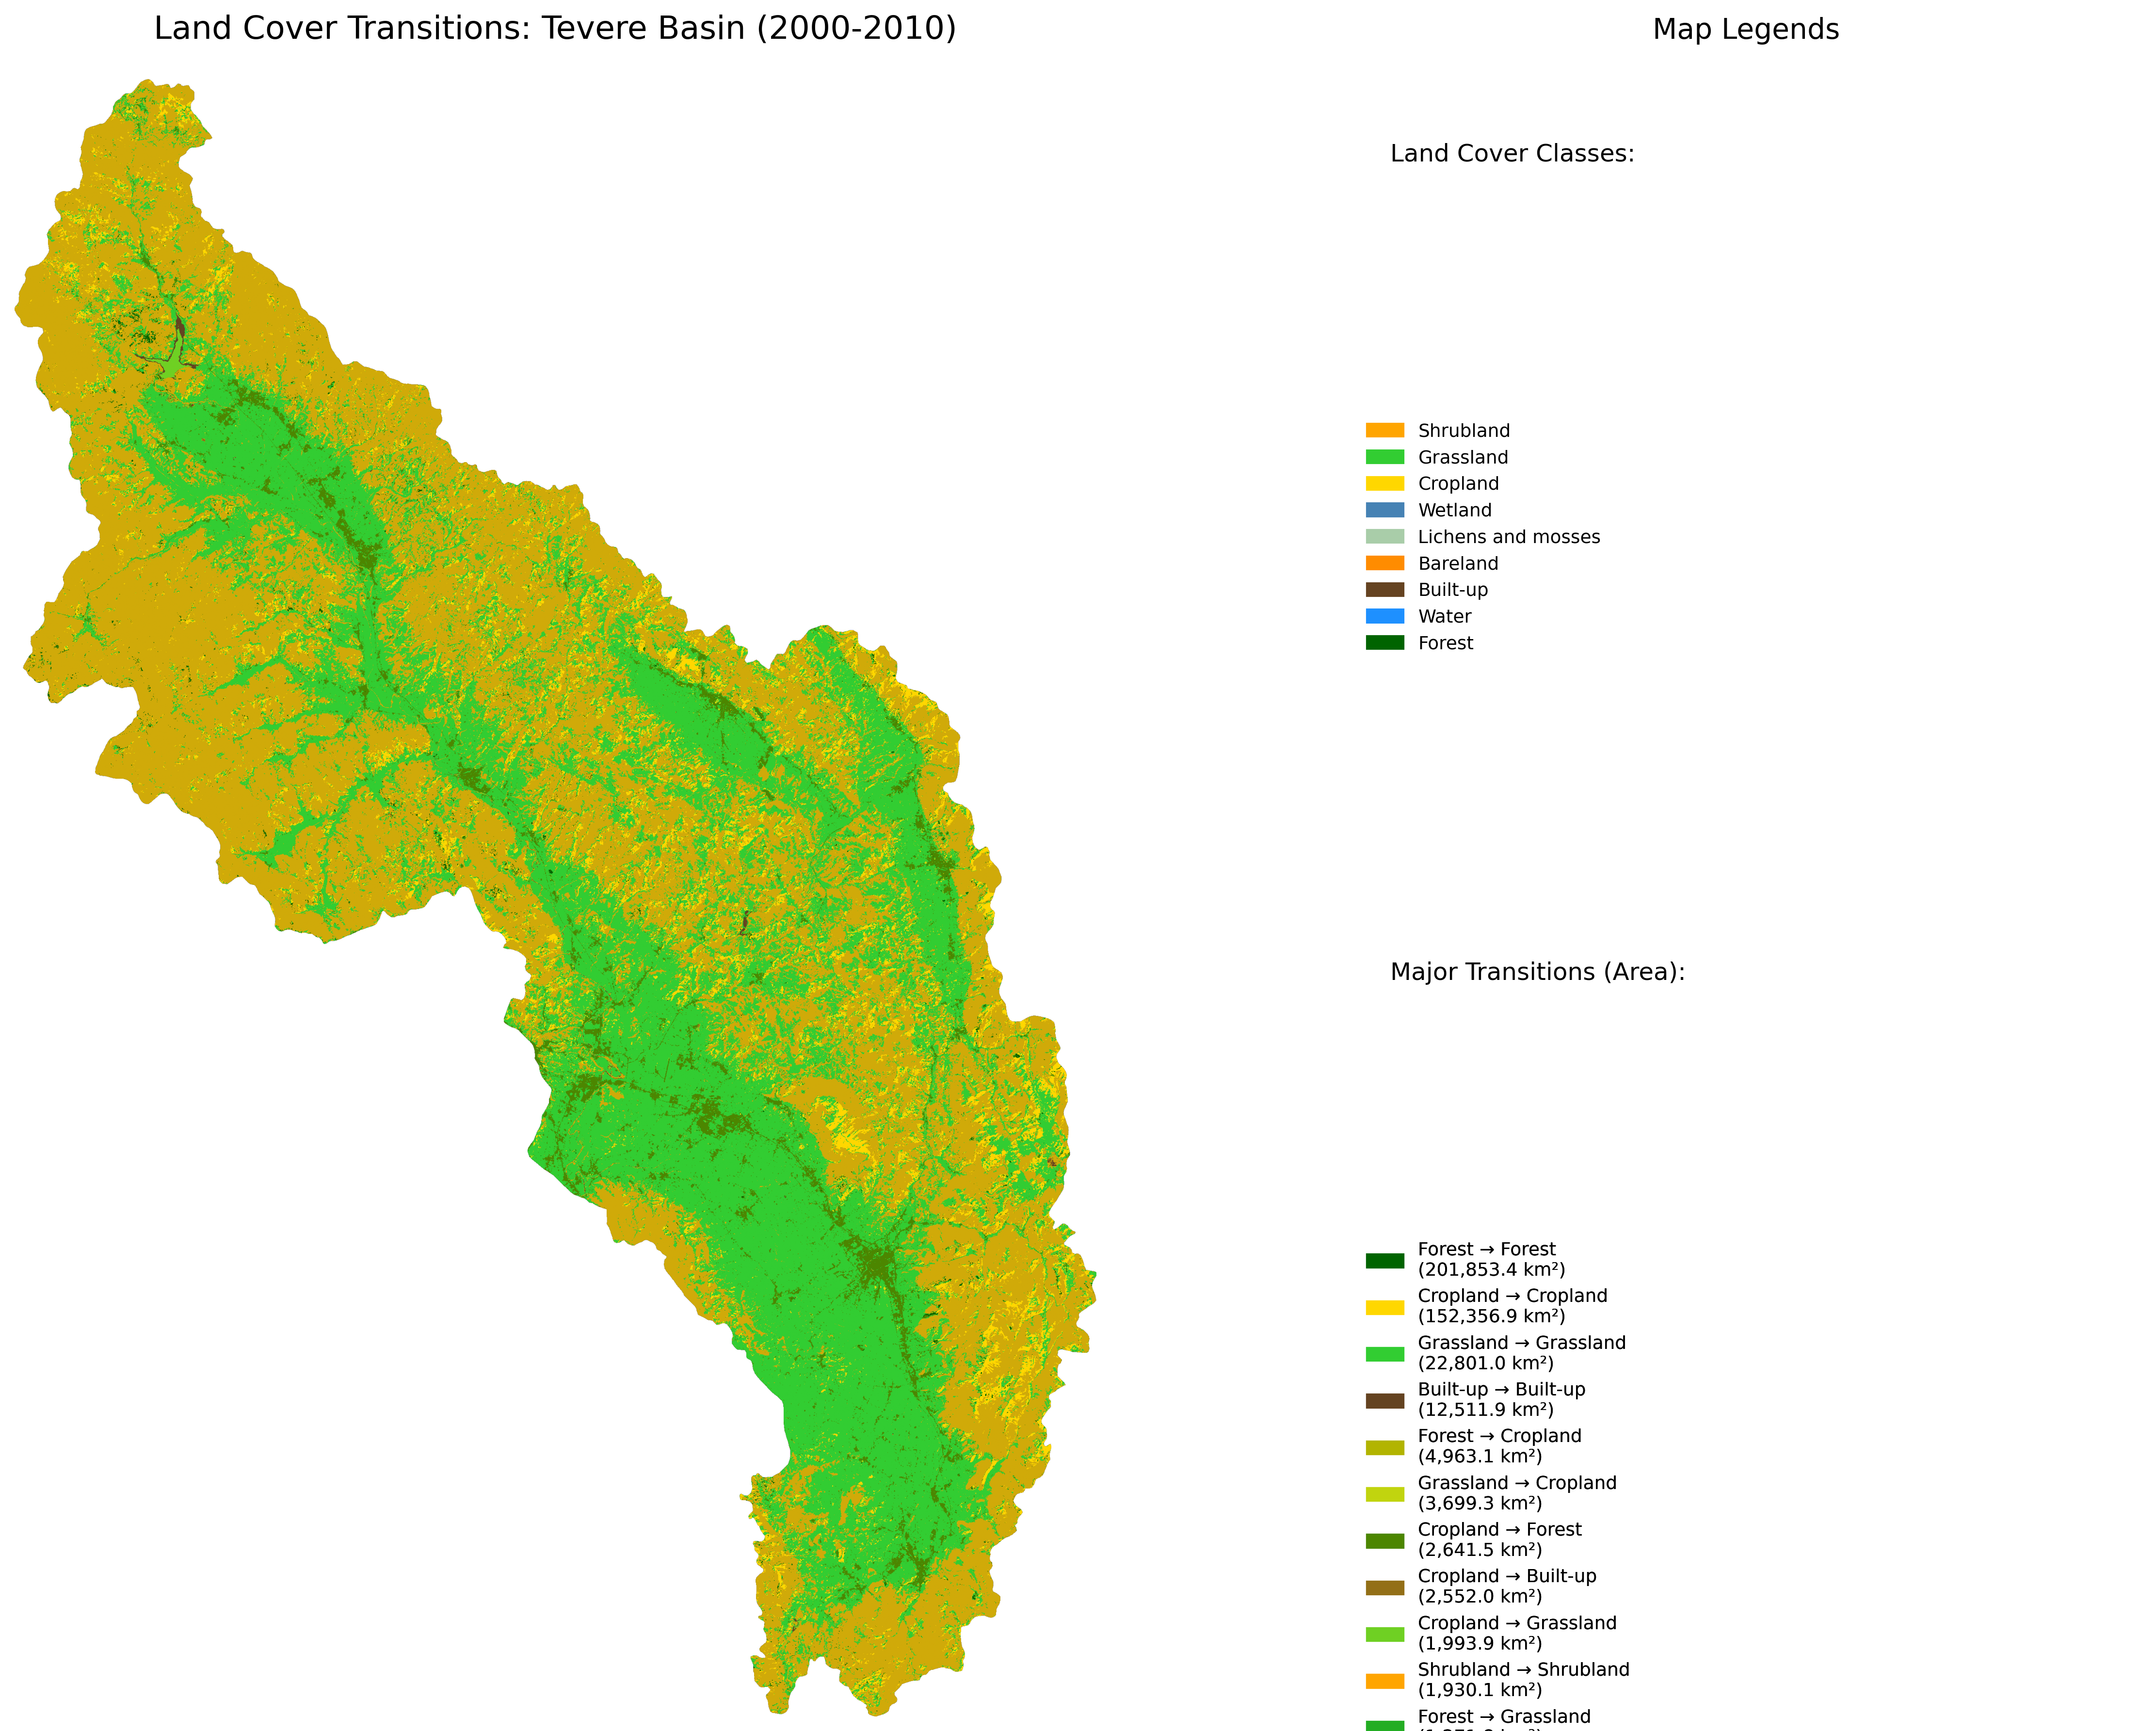

In [23]:
import os
import sys
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import grass.script as gs
import grass.script.setup as gsetup
import rasterio
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Setup GRASS environment
gisbase = '/Applications/GRASS-8.4.app/Contents/Resources'
gisdb = '/Users/ghulamabbaszafari/grassdata'
location = 'my_location'
mapset = 'PERMANENT'

os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdb
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset
sys.path.append(os.path.join(gisbase, 'etc', 'python'))
gsetup.init(gisdb, location, mapset)

# Transition map to visualize
raster_map = 'tevere_30m_transition_visual_2000_2010'

# Class definitions
class_labels = {
    5: "Shrubland",
    7: "Grassland",
    8: "Cropland",
    9: "Wetland",
    11: "Lichens and mosses",
    12: "Bareland",
    13: "Built-up",
    15: "Water",
    16: "Permanent ice and Snow",
    20: "Forest",
    255: "No data"
}

# Color mapping with your specified colors
color_map = {
    "Shrubland": '#FFA500',        # Bright orange/brown
    "Grassland": '#32cd32',        # Lime green
    "Cropland": '#ffd700',         # Gold
    "Wetland": '#4682b4',          # Steel blue
    "Lichens and mosses": '#a9cda9', # Light green
    "Bareland": '#FF8C00',         # Dark orange
    "Built-up": '#654321',         # Dark brown
    "Water": '#1e90ff',            # Dodger blue
    "Permanent ice and Snow": '#b0c4de', # Light steel blue
    "Forest": '#006400',           # Dark green
    "No data": '#ffffff'           # White
}
def visualize_transition_map():
    """Visualize transition map with class colors and transition legend"""
    # Set computational region
    gs.run_command('g.region', raster=raster_map)
    
    # Reset any existing color table
    gs.run_command('r.colors', map=raster_map, flags='r')
    
    # Get all unique transition codes and their counts
    print("Analyzing transition statistics...")
    stats = gs.read_command("r.stats", flags="cn", input=raster_map, sep=":").strip()
    transitions = []
    for line in stats.splitlines():
        if ':' in line:
            code, count = line.split(":")
            transitions.append((int(code), int(count)))
    
    # Sort transitions by count (descending)
    transitions.sort(key=lambda x: x[1], reverse=True)
    
    # Create color rules and legend entries
    print("Generating color rules for transitions...")
    color_rules = []
    class_legend_entries = []
    transition_legend_entries = []
    
    for code, count in transitions:
        from_class = code // 1000
        to_class = code % 1000
        
        # Add to class legend
        if to_class in CLASS_LABELS:
            class_legend_entries.append((to_class, CLASS_LABELS[to_class], COLOR_MAP.get(to_class, '#ffffff')))
        
        # Create blended color for transitions
        if from_class in COLOR_MAP and to_class in COLOR_MAP:
            from_color = COLOR_MAP[from_class]
            to_color = COLOR_MAP[to_class]
            
            # Weighted color blending
            r = int(0.3*int(from_color[1:3], 16) + 0.7*int(to_color[1:3], 16))
            g = int(0.3*int(from_color[3:5], 16) + 0.7*int(to_color[3:5], 16))
            b = int(0.3*int(from_color[5:7], 16) + 0.7*int(to_color[5:7], 16))
            blended_color = f"#{r:02x}{g:02x}{b:02x}"
            color_rules.append(f"{code} {blended_color}")
            
            # Add to transition legend (top 12)
            if len(transition_legend_entries) < 12:
                from_label = CLASS_LABELS.get(from_class, f"Class {from_class}")
                to_label = CLASS_LABELS.get(to_class, f"Class {to_class}")
                area_km2 = count * 0.09  # 30m resolution (0.09 ha/pixel)
                transition_legend_entries.append((code, blended_color, f"{from_label} → {to_label}", area_km2))
    
    # Apply color rules
    print("Applying color rules...")
    if color_rules:
        gs.write_command("r.colors", map=raster_map, rules="-", stdin="\n".join(color_rules))
    
    # Export raster (using UInt16 to avoid TIFF color table issue)
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_tif = os.path.join(tmpdirname, 'temp_raster.tif')
        
        print("Exporting raster data...")
        gs.run_command('r.out.gdal', 
                      input=raster_map, 
                      output=temp_tif, 
                      format='GTiff',
                      type='UInt16',  # Changed from UInt32 to avoid TIFF color table issue
                      nodata=0,
                      createopt='COMPRESS=LZW',
                      overwrite=True)
        
        with rasterio.open(temp_tif) as src:
            raster_array = src.read(1)
            nodata = src.nodata
            raster_masked = np.ma.masked_equal(raster_array, nodata)
            
            print("Creating visualization...")
            fig = plt.figure(figsize=(18, 12), dpi=300)
            gs_fig = GridSpec(1, 2, width_ratios=[2.5, 1])
            
            # Create colormap from transition colors
            transition_codes = [item[0] for item in transition_legend_entries]
            transition_colors = [item[1] for item in transition_legend_entries]
            cmap = ListedColormap(transition_colors)
            norm = plt.Normalize(vmin=min(transition_codes), vmax=max(transition_codes))
            
            # Map plot
            ax1 = fig.add_subplot(gs_fig[0])
            im = ax1.imshow(raster_masked, cmap=cmap, norm=norm)
            ax1.set_title('Land Cover Transitions: Tevere Basin (2000-2010)', fontsize=16, pad=20)
            ax1.axis('off')
            
            # Legend area
            ax2 = fig.add_subplot(gs_fig[1])
            ax2.axis('off')
            
            # Create class legend (unique entries)
            unique_classes = {v[0]:v for v in class_legend_entries}.values()
            class_patches = [Patch(color=color, label=label) 
                           for val, label, color in sorted(unique_classes, key=lambda x: x[0])]
            
            # Create transition legend
            trans_patches = [Patch(color=color, label=f"{label}\n({area:,.1f} km²)") 
                           for code, color, label, area in transition_legend_entries]
            
            # Add legends
            ax2.set_title('Map Legends', fontsize=14, pad=20)
            
            # Class legend
            ax2.text(0.05, 0.95, 'Land Cover Classes:', fontsize=12, transform=ax2.transAxes)
            class_legend = ax2.legend(handles=class_patches, 
                                    loc='upper left', 
                                    bbox_to_anchor=(0, 0.8), 
                                    frameon=False, 
                                    fontsize=9)
            
            # Transition legend
            ax2.text(0.05, 0.45, 'Major Transitions (Area):', fontsize=12, transform=ax2.transAxes)
            trans_legend = ax2.legend(handles=trans_patches, 
                                    loc='upper left', 
                                    bbox_to_anchor=(0, 0.3), 
                                    frameon=False, 
                                    fontsize=9)
            
            ax2.add_artist(class_legend)
            ax2.add_artist(trans_legend)
            
            plt.tight_layout()
            
            # Save output
            output_dir = "transition_maps"
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{raster_map}_visualization.png")
            fig.savefig(output_file, dpi=600, format='png', bbox_inches='tight')
            print(f"\n✔ Visualization saved to: {output_file}")
            
            plt.show()

# Run the visualization
print(f"Starting visualization of {raster_map}...")
visualize_transition_map()




Preparing transition matrix...
Creating chord diagram...


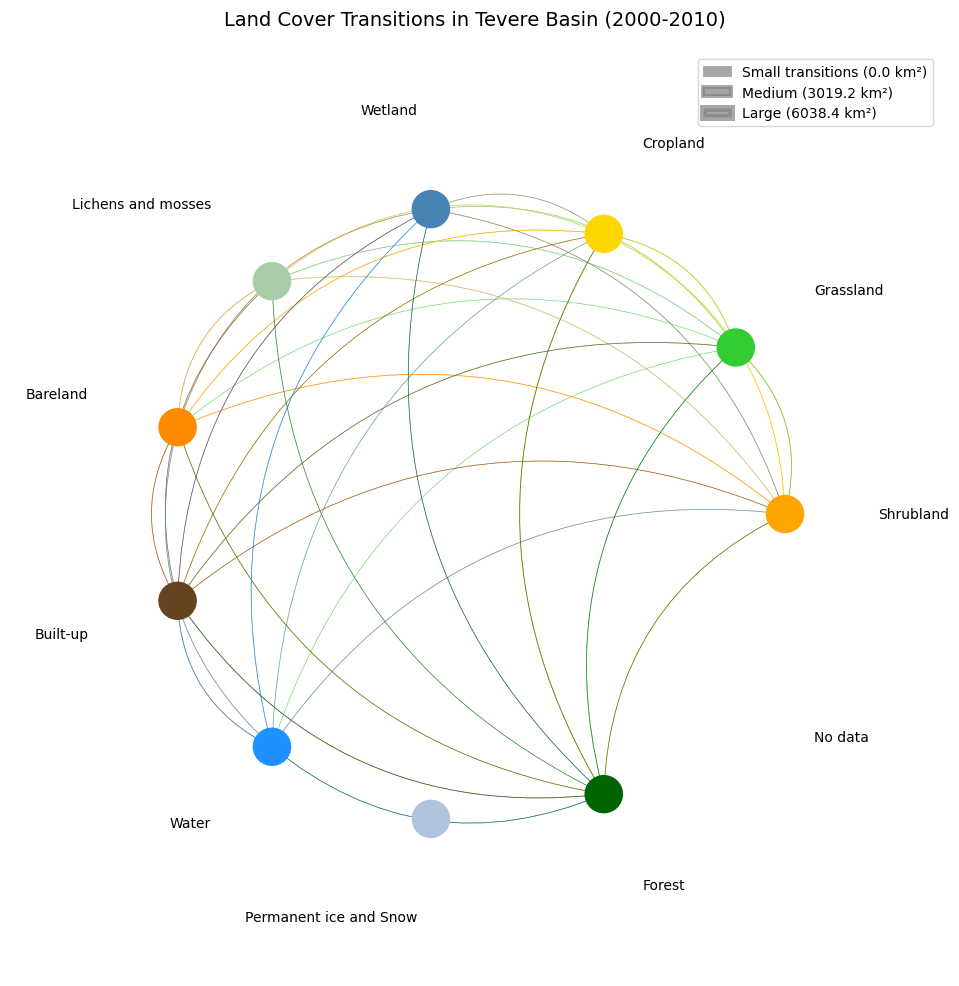

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch

# Load your data
file_path = '/Users/ghulamabbaszafari/Downloads/Abbas new/Thesis_project/data/Tevre_clipped _esa_cci/Lc_GLC/tevere_30m_transition_matrix_ALL.csv'
df = pd.read_csv(file_path)

# Class definitions with colors
class_info = {
    5: {'name': 'Shrubland', 'color': '#FFA500'},
    7: {'name': 'Grassland', 'color': '#32cd32'},
    8: {'name': 'Cropland', 'color': '#ffd700'},
    9: {'name': 'Wetland', 'color': '#4682b4'},
    11: {'name': 'Lichens and mosses', 'color': '#a9cda9'},
    12: {'name': 'Bareland', 'color': '#FF8C00'},
    13: {'name': 'Built-up', 'color': '#654321'},
    15: {'name': 'Water', 'color': '#1e90ff'},
    16: {'name': 'Permanent ice and Snow', 'color': '#b0c4de'},
    20: {'name': 'Forest', 'color': '#006400'},
    255: {'name': 'No data', 'color': '#ffffff'}
}

# Prepare matrix for chord diagram - FIXED to handle duplicates
def prepare_matrix(df, class_info):
    # Aggregate duplicate From-To pairs by summing their areas
    df_agg = df.groupby(['From', 'To'])['Area_km2'].sum().reset_index()
    
    # Create pivot table
    matrix = df_agg.pivot(index='From', columns='To', values='Area_km2').fillna(0)
    
    # Ensure all classes are included (even if no transitions)
    all_classes = sorted(class_info.keys())
    return matrix.reindex(index=all_classes, columns=all_classes, fill_value=0)

# Create the plot
def create_chord_diagram(matrix, class_info):
    # Setup figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Create colormap
    colors = [class_info[code]['color'] for code in sorted(class_info.keys())]
    
    # Normalize values for line width
    non_zero_values = matrix.values[matrix.values > 0]
    if len(non_zero_values) == 0:
        print("Warning: No transitions found in the data!")
        return
    
    max_val = np.max(non_zero_values)
    min_val = np.min(non_zero_values)
    norm_val = lambda x: 0.5 + 4.5 * (x - min_val) / (max_val - min_val)
    
    # Plot nodes first
    node_positions = {}
    n_classes = len(class_info)
    radius = 5
    for i, code in enumerate(matrix.index):
        angle = 2 * np.pi * i / n_classes
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        node_positions[code] = (x, y)
        circle = plt.Circle((x, y), 0.3, color=class_info[code]['color'], zorder=3)
        ax.add_patch(circle)
        
        # Adjust text position based on angle
        text_x = x * 1.3
        text_y = y * 1.3
        ha = 'left' if x > 0 else 'right' if x < 0 else 'center'
        va = 'bottom' if y > 0 else 'top' if y < 0 else 'center'
        
        plt.text(text_x, text_y, class_info[code]['name'], 
                ha=ha, va=va, fontsize=10)
    
    # Plot connections
    for i, from_class in enumerate(matrix.index):
        for j, to_class in enumerate(matrix.columns):
            value = matrix.at[from_class, to_class]
            if value > 0 and from_class != to_class:  # Skip self-transitions
                x1, y1 = node_positions[from_class]
                x2, y2 = node_positions[to_class]
                
                # Create curved connection
                con = ConnectionPatch(
                    xyA=(x1, y1), 
                    xyB=(x2, y2),
                    coordsA="data", 
                    coordsB="data",
                    arrowstyle="-|>", 
                    mutation_scale=20,
                    lw=norm_val(value),
                    color=class_info[from_class]['color'],
                    alpha=0.7,
                    connectionstyle=f"arc3,rad={0.3 if i < j else -0.3}"
                )
                ax.add_patch(con)
    
    # Set limits
    ax.set_xlim(-radius*1.5, radius*1.5)
    ax.set_ylim(-radius*1.5, radius*1.5)
    ax.axis('off')
    
    # Add title
    plt.title('Land Cover Transitions in Tevere Basin (2000-2010)', pad=20, fontsize=14)
    
    # Add legend for line widths
    if max_val != min_val:
        legend_patches = [
            mpatches.Patch(color='gray', alpha=0.7, 
                          linewidth=norm_val(min_val), 
                          label=f'Small transitions ({min_val:.1f} km²)'),
            mpatches.Patch(color='gray', alpha=0.7, 
                          linewidth=norm_val((max_val+min_val)/2), 
                          label=f'Medium ({(max_val+min_val)/2:.1f} km²)'),
            mpatches.Patch(color='gray', alpha=0.7, 
                          linewidth=norm_val(max_val), 
                          label=f'Large ({max_val:.1f} km²)')
        ]
        plt.legend(handles=legend_patches, loc='upper right', fontsize=10)
    
    # Save high-quality version
    plt.savefig('tevere_land_cover_transitions.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Prepare data and create plot
print("Preparing transition matrix...")
matrix = prepare_matrix(df, class_info)
print("Creating chord diagram...")
create_chord_diagram(matrix, class_info)

